# Imports

Import basic packages

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [96]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Read The Data

In [30]:
txt_data = []
relative_path = os.path.join(os.getcwd(), 'data', 'AdienceBenchmarkGenderAndAgeClassification')

for file in os.listdir(relative_path):
    if file.endswith('.txt'):
       txt_data.append(pd.read_csv(os.path.join(relative_path, file), sep='\t'))

raw_data = pd.concat(txt_data, ignore_index=True)

Columns description:

1. user_id - folder name with correct images 
2. orginal_image - name of image in the folder
3. face_id - id of face on the image
4. age - age feature 
5. gender - gender feature 

In [31]:
raw_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [32]:
#Create an absolute paths to dataset which contains images for our model
#Path should look like follows - path to folder with data/ faces/ user_id/ 'coarse_tilt_aligned_face.'/ face_id/ orginal_image

raw_data.loc[:, 'img_folder_path'] = raw_data.apply(lambda row: os.path.join(relative_path, 'faces', row.user_id), axis=1)
raw_data.loc[:, 'img_name'] = raw_data.apply(lambda row: 'coarse_tilt_aligned_face.' + str(row.face_id) + '.' + row.original_image, axis=1)
raw_data.loc[:, 'img_absolute_path'] = raw_data.apply(lambda row: os.path.join(row.img_folder_path, row.img_name), axis=1)

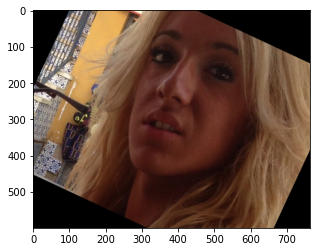

In [33]:
#Check if the absolute path loads images from a folder

from keras.preprocessing.image import load_img

img = load_img(raw_data.img_absolute_path.iloc[0])
plt.imshow(img)
plt.show()

# Preprocessing dataset


1. Check if data contains a missing values

In [34]:
raw_data.isnull().sum()

user_id                 0
original_image          0
face_id                 0
age                     0
gender                779
x                       0
y                       0
dx                      0
dy                      0
tilt_ang                0
fiducial_yaw_angle      0
fiducial_score          0
img_folder_path         0
img_name                0
img_absolute_path       0
dtype: int64

In [35]:
#Drop NA data from gender column
raw_data.dropna(subset=['gender'], inplace=True)

In [36]:
# f = female, m=male, u=unidentified 
raw_data.gender.value_counts()

f    9372
m    8120
u    1099
Name: gender, dtype: int64

In [37]:
#Drop 'u' data from gender which is unidentified
raw_data = raw_data[raw_data.gender != 'u']

In [38]:
#Look at age column
raw_data.age.unique()

array(['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)',
       '(48, 53)', '(8, 12)', '(0, 2)', '(38, 48)', '35', '3', '55', '58',
       '22', '13', '45', '36', '23', '(38, 42)', 'None', '(8, 23)',
       '(27, 32)', '57', '2', '29', '34', '42', '46'], dtype=object)

In [39]:
#Drop data where age is unkonow
raw_data = raw_data[raw_data.age != 'None']

In [40]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             17452 non-null  object
 1   original_image      17452 non-null  object
 2   face_id             17452 non-null  int64 
 3   age                 17452 non-null  object
 4   gender              17452 non-null  object
 5   x                   17452 non-null  int64 
 6   y                   17452 non-null  int64 
 7   dx                  17452 non-null  int64 
 8   dy                  17452 non-null  int64 
 9   tilt_ang            17452 non-null  int64 
 10  fiducial_yaw_angle  17452 non-null  int64 
 11  fiducial_score      17452 non-null  int64 
 12  img_folder_path     17452 non-null  object
 13  img_name            17452 non-null  object
 14  img_absolute_path   17452 non-null  object
dtypes: int64(8), object(7)
memory usage: 2.1+ MB


In [41]:
#Select data which will be needed to train and test models
data = raw_data[['age', 'gender', 'img_absolute_path']]

In [42]:
#Encode gender categorical data to numeric 
data = data.replace({'gender': {'f': 0, 'm': 1}})

In [43]:
#Encode age values
data.age.unique()

array(['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)',
       '(48, 53)', '(8, 12)', '(0, 2)', '(38, 48)', '35', '3', '55', '58',
       '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)', '(27, 32)',
       '57', '2', '29', '34', '42', '46'], dtype=object)

In [44]:
#Manual age mapping list with correct age structure
age_mapping= [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), 
('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), 
('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), 
('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

#Make a dict for a correct age structure
age_mapping_dict = {x[0]: x[1] for x in age_mapping}

In [45]:
#Encode categorical age data to numeric
age_dict =  {'0-2': 0, '4-6': 1, '8-13': 2, '15-20': 3, '25-32': 4, '38-43': 5, '48-53': 6, '60+': 7}
data.loc[:, 'age'] = data.apply(lambda row: age_dict[age_mapping_dict[row.age]], axis=1)

In [46]:
data.head()

,age,gender,img_absolute_path
0,4,0,f:\Data_Science\5_Projects\gender_age_detectio...
1,4,1,f:\Data_Science\5_Projects\gender_age_detectio...
2,4,0,f:\Data_Science\5_Projects\gender_age_detectio...
3,4,1,f:\Data_Science\5_Projects\gender_age_detectio...
4,4,1,f:\Data_Science\5_Projects\gender_age_detectio...


# Train Test Split

Split data on train_test values, in our case we split the absolute path to folders, where we store ours images. 
After this step we will preproces each image and store them in the lists. 

In [47]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_gender = data['img_absolute_path']
y_gender = to_categorical(data['gender'])

X_age = data['img_absolute_path']
y_age = to_categorical(data['age'])


X_train_gender, X_test_gender, y_train_gedner, y_test_gender = train_test_split(X_gender, y_gender, test_size=0.2, random_state=42)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

# Images Preprocesing

1. Gender train and test images preprocesing

In [48]:
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image

def resize_array_img(img_path): 
    image_array = img_to_array(Image.open(img_path).resize((224, 224)))
    return image_array

train_images_gender = []
test_images_gender = []

for img_path in X_train_gender:
    img_data = resize_array_img(img_path=img_path)
    train_images_gender.append(img_data)


for img_path in X_test_gender:
    img_data = resize_array_img(img_path=img_path)
    test_images_gender.append(img_data)


train_images_gender =  np.asarray(train_images_gender) / 255
test_images_gender =  np.asarray(test_images_gender) / 255



2. Age train and test images preprocesing

In [49]:
train_images_age = []
test_images_age = []

for img_path in X_train_age:
    img_data = resize_array_img(img_path=img_path)
    train_images_age.append(img_data)


for img_path in X_test_age:
    img_data = resize_array_img(img_path=img_path)
    test_images_age.append(img_data)

train_images_age =  np.asarray(train_images_age) / 255
test_images_age =  np.asarray(test_images_age) / 255



# Create gender and age models

0. Early Stopping

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

1. Create a gender model base on traning dataset

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LayerNormalization

def create_gender_model():
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(7, 7), strides=4, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='valid'))
    model.add(LayerNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(LayerNormalization())

    model.add(Conv2D(filters=384, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(LayerNormalization())

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.15))

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(units=2, activation='softmax'))

    return model

In [56]:
gender_model = create_gender_model()
gender_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 56, 56, 96)        14208     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 layer_normalization_6 (Laye  (None, 27, 27, 96)       192       
 rNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 256)       221440    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                      

In [57]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
gender_model.compile(loss="categorical_crossentropy", 
                     optimizer=optimizer, 
                     metrics=["categorical_accuracy"])

In [58]:
gender_model.fit(train_images_gender, y_train_gedner,
                 epochs=50,
                 batch_size=32,
                 callbacks=[early_stopping],
                 validation_split=0.2)

Epoch 1/50
349/349 [==============================] - 182s 513ms/step - loss: 0.7286 - categorical_accuracy: 0.5809 - val_loss: 0.5670 - val_categorical_accuracy: 0.7093
Epoch 2/50
349/349 [==============================] - 175s 502ms/step - loss: 0.5748 - categorical_accuracy: 0.6988 - val_loss: 0.5749 - val_categorical_accuracy: 0.6867
Epoch 3/50
349/349 [==============================] - 173s 497ms/step - loss: 0.4887 - categorical_accuracy: 0.7573 - val_loss: 0.3985 - val_categorical_accuracy: 0.8160
Epoch 4/50
349/349 [==============================] - 173s 496ms/step - loss: 0.3990 - categorical_accuracy: 0.8173 - val_loss: 0.3510 - val_categorical_accuracy: 0.8357
Epoch 5/50
349/349 [==============================] - 184s 528ms/step - loss: 0.3358 - categorical_accuracy: 0.8495 - val_loss: 0.3140 - val_categorical_accuracy: 0.8589
Epoch 6/50
349/349 [==============================] - 180s 515ms/step - loss: 0.2764 - categorical_accuracy: 0.8829 - val_loss: 0.2937 - val_categoric

In [59]:
from sklearn.metrics import accuracy_score
print(f'Test accuracy : {accuracy_score(y_test_gender.argmax(1), gender_model.predict(test_images_gender).argmax(1))}' + '\n' +
      f'Train accuracy: {accuracy_score(y_train_gedner.argmax(1), gender_model.predict(train_images_gender).argmax(1))}')

Test accuracy : 0.8965912346032655
Train accuracy: 0.9750734188095409


2. Train a model with a transfer learning using a VGG16 pretrained model


In [65]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze base_model, only train the top leayrs
base_model.trainable = False

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LayerNormalization

def create_transfer_gender_model():
    model = Sequential()
    model.add(Flatten())

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.15))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(units=2, activation='softmax'))

    return model

In [83]:
transfer_gender_model = create_transfer_gender_model()

In [84]:
transfer_model_gender = Sequential()
transfer_model_gender.add(base_model)
transfer_model_gender.add(transfer_gender_model)
transfer_model_gender.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_12 (Sequential)  (None, 2)                 6455938   
                                                                 
Total params: 21,170,626
Trainable params: 6,455,938
Non-trainable params: 14,714,688
_________________________________________________________________


In [86]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
transfer_model_gender.compile(loss="categorical_crossentropy", 
                     optimizer=optimizer, 
                     metrics=["categorical_accuracy"])

In [87]:
transfer_model_gender.fit(train_images_gender, y_train_gedner,
                 epochs=50,
                 batch_size=32,
                 callbacks=[early_stopping],
                 validation_split=0.2)

Epoch 1/50
349/349 [==============================] - 1994s 6s/step - loss: 0.5683 - categorical_accuracy: 0.7402 - val_loss: 0.3672 - val_categorical_accuracy: 0.8382
Epoch 2/50
349/349 [==============================] - 1977s 6s/step - loss: 0.3857 - categorical_accuracy: 0.8198 - val_loss: 0.3343 - val_categorical_accuracy: 0.8500
Epoch 3/50
349/349 [==============================] - 2002s 6s/step - loss: 0.3307 - categorical_accuracy: 0.8471 - val_loss: 0.3262 - val_categorical_accuracy: 0.8525
Epoch 4/50
349/349 [==============================] - 1979s 6s/step - loss: 0.2673 - categorical_accuracy: 0.8741 - val_loss: 0.3244 - val_categorical_accuracy: 0.8528
Epoch 5/50
349/349 [==============================] - 1986s 6s/step - loss: 0.2294 - categorical_accuracy: 0.8956 - val_loss: 0.3215 - val_categorical_accuracy: 0.8654
Epoch 6/50
349/349 [==============================] - 2071s 6s/step - loss: 0.2110 - categorical_accuracy: 0.9026 - val_loss: 0.3663 - val_categorical_accuracy:

In [97]:
from sklearn.metrics import accuracy_score
print(f'Test accuracy : {accuracy_score(y_test_gender.argmax(1), transfer_model_gender.predict(test_images_gender).argmax(1))}' + '\n' +
      f'Train accuracy: {accuracy_score(y_train_gedner.argmax(1), transfer_model_gender.predict(train_images_gender).argmax(1))}')

Test accuracy : 0.8733887138355771
Train accuracy: 0.9442733328558126


3. Create Age Model

1. Create an age model base on traning dataset

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LayerNormalization

def create_age_model():
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(7, 7), strides=4, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='valid'))
    model.add(LayerNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(LayerNormalization())

    model.add(Conv2D(filters=384, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(LayerNormalization())

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.15))

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(units=8, activation='softmax'))

    return model

In [61]:
age_model = create_age_model()
age_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 56, 56, 96)        14208     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 layer_normalization_9 (Laye  (None, 27, 27, 96)       192       
 rNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 128)       110720    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                      

In [62]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
age_model.compile(loss="categorical_crossentropy", 
                     optimizer=optimizer, 
                     metrics=["categorical_accuracy"])

In [63]:
age_model.fit(train_images_age, y_train_age,
                 epochs=50,
                 batch_size=32,
                 callbacks=[early_stopping],
                 validation_split=0.2)

Epoch 1/50
349/349 [==============================] - 120s 343ms/step - loss: 1.9818 - categorical_accuracy: 0.2718 - val_loss: 1.8653 - val_categorical_accuracy: 0.3265
Epoch 2/50
349/349 [==============================] - 121s 348ms/step - loss: 1.8513 - categorical_accuracy: 0.3096 - val_loss: 1.7397 - val_categorical_accuracy: 0.3491
Epoch 3/50
349/349 [==============================] - 124s 357ms/step - loss: 1.7149 - categorical_accuracy: 0.3582 - val_loss: 1.6641 - val_categorical_accuracy: 0.3713
Epoch 4/50
349/349 [==============================] - 129s 370ms/step - loss: 1.5834 - categorical_accuracy: 0.3988 - val_loss: 1.4782 - val_categorical_accuracy: 0.4382
Epoch 5/50
349/349 [==============================] - 130s 374ms/step - loss: 1.4355 - categorical_accuracy: 0.4459 - val_loss: 1.3704 - val_categorical_accuracy: 0.4844
Epoch 6/50
349/349 [==============================] - 129s 369ms/step - loss: 1.2936 - categorical_accuracy: 0.4995 - val_loss: 1.2725 - val_categoric

In [64]:
from sklearn.metrics import accuracy_score
print(f'Test accuracy : {accuracy_score(y_test_age.argmax(1), age_model.predict(test_images_age).argmax(1))}' + '\n' +
      f'Train accuracy: {accuracy_score(y_train_age.argmax(1), age_model.predict(train_images_age).argmax(1))}')

Test accuracy : 0.6413635061586938
Train accuracy: 0.9295179428407707


2. Train an age model with tranfser learning

In [88]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze base_model, only train the top leayrs
base_model.trainable = False

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def create_transfer_age_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(units=8, activation='softmax'))

    return model

In [90]:
transfer_age_model = create_transfer_age_model()

In [91]:
transfer_model_age = Sequential()
transfer_model_age.add(base_model)
transfer_model_age.add(transfer_age_model)
transfer_model_age.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_14 (Sequential)  (None, 8)                 6456712   
                                                                 
Total params: 21,171,400
Trainable params: 6,456,712
Non-trainable params: 14,714,688
_________________________________________________________________


In [92]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
transfer_model_age.compile(loss="categorical_crossentropy", 
                     optimizer=optimizer, 
                     metrics=["categorical_accuracy"])

In [93]:
transfer_model_age.fit(train_images_age, y_train_age,
                 epochs=50,
                 batch_size=32,
                 callbacks=[early_stopping],
                 validation_split=0.1)

Epoch 1/50
393/393 [==============================] - 2016s 5s/step - loss: 1.7873 - categorical_accuracy: 0.3355 - val_loss: 1.4758 - val_categorical_accuracy: 0.4209
Epoch 2/50
393/393 [==============================] - 2006s 5s/step - loss: 1.5408 - categorical_accuracy: 0.4001 - val_loss: 1.4393 - val_categorical_accuracy: 0.4488
Epoch 3/50
393/393 [==============================] - 2009s 5s/step - loss: 1.4492 - categorical_accuracy: 0.4291 - val_loss: 1.3421 - val_categorical_accuracy: 0.4588
Epoch 4/50
393/393 [==============================] - 2017s 5s/step - loss: 1.3800 - categorical_accuracy: 0.4407 - val_loss: 1.3417 - val_categorical_accuracy: 0.4517
Epoch 5/50
393/393 [==============================] - 2028s 5s/step - loss: 1.3340 - categorical_accuracy: 0.4530 - val_loss: 1.3446 - val_categorical_accuracy: 0.4431
Epoch 6/50
393/393 [==============================] - 2010s 5s/step - loss: 1.2785 - categorical_accuracy: 0.4736 - val_loss: 1.2572 - val_categorical_accuracy:

In [94]:
from sklearn.metrics import accuracy_score
print(f'Test accuracy : {accuracy_score(y_test_age.argmax(1), transfer_model_age.predict(test_images_age).argmax(1))}' + '\n' +
      f'Train accuracy: {accuracy_score(y_train_age.argmax(1), transfer_model_age.predict(train_images_age).argmax(1))}')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Test accuracy : 0.5161844743626468
Train accuracy: 0.7576104863548456


# Save gender and age models

In [168]:
transfer_model_gender.save('ml_model/gender_model.h5')
transfer_model_age.save('ml_model/age_model.h5')